## LSTM (Youtube video sentiments)

Wei Li

In [1]:
import os
import csv
import time
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split

# random_seed = 123
# os.environ["PL_GLOBAL_SEED"] = str(random_seed)
# random.seed(random_seed)
# np.random.seed(random_seed)

In [2]:
# %pip install watermark
%load_ext watermark
%watermark -a "Wei Li" -u -t -d -v -p numpy,torch,torchtext

Author: Wei Li

Last updated: 2023-12-30 10:04:06

Python implementation: CPython
Python version       : 3.8.17
IPython version      : 8.12.2

numpy    : 1.21.5
torch    : 1.12.1
torchtext: 0.13.1



In [3]:
# From local helper files
from utils_evaluation import (
    set_all_seeds,
    set_deterministic,
)
from utils_plotting import plot_accuracy, plot_loss, plot_confusion_matrix

In [4]:
## Setting 
RANDOM_SEED = 2022
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
set_all_seeds(RANDOM_SEED)
set_deterministic()

In [5]:
# data https://www.kaggle.com/datasets/advaypatil/youtube-statistics
# videos-stats.csv:
# This file contains some basic information about each video, such as the title, likes, views, keyword, and comment count.

# comments.csv:
# For each video in videos-stats.csv, comments.csv contains the top ten most relevant comments as well as said comments' sentiments and likes.

# We shall use comments.csv for the task, i.e., predicting the sentiment.
# A value of 0 represents a negative sentiment, while values of 1 or 2 represent neutral and positive sentiments respectively.

,Unnamed: 0,Video ID,Comment,Likes,Sentiment
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0


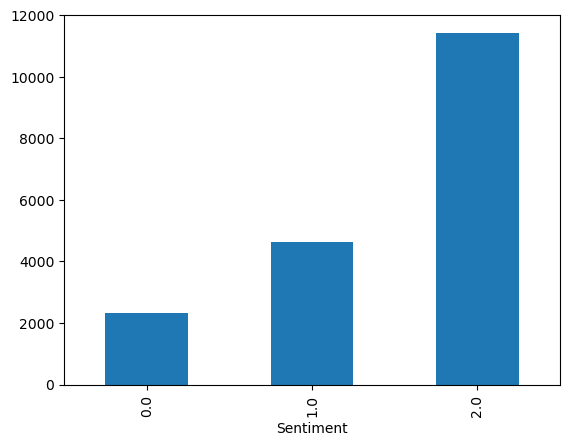

In [6]:
DATA_DIR = "/Users/wli169/Documents/Work/datasets/"

# read the data
comment = pd.read_csv(DATA_DIR + "YoutubeStatistics/comments.csv")
comment.groupby("Sentiment").count()["Comment"].plot.bar()
# look at data
comment.head(5)

In [7]:
# check the third comment
comment.iloc[3, 2]

'Whenever I go to a place that doesn’t take Apple Pay (doesn’t happen too often), it’s such a drag. Between ‘contactless Covid’ habits and my getting the Apple Card, I’ve gotten so used to Apple Pay that I get seriously annoyed when a store doesn’t take it. It feels like a shock, it’s crazy how quickly it took over my shopping routine! I’ve officially been brainwashed by Apple because now it feels so inconvenient to even carry a physical card in my pocket.'

In [8]:
comment.describe()

,Unnamed: 0,Likes,Sentiment
count,18409.000000,18409.000000,18409.000000
mean,9204.000000,1040.019447,1.493998
std,5314.364888,10651.366148,0.709928
min,0.000000,0.000000,0.000000
25%,4602.000000,5.000000,1.000000
50%,9204.000000,29.000000,2.000000
75%,13806.000000,190.000000,2.000000
max,18408.000000,891372.000000,2.000000


In [9]:
# have 1 null data in comment
comment.isnull().sum()
# look at null data
comment[comment["Comment"].isnull()]
# Drop the row 9745
comment = comment.drop(9745)

In [10]:
# drop the other columns
comment_data = comment.drop(columns=["Unnamed: 0", "Video ID", "Likes"])
comment_data.groupby("Sentiment").count()
# 2338 + 4638 + 11432 = 18408 (exluding one NaN comment)

,Comment
Sentiment,
0.0,2338
1.0,4638
2.0,11432


In [11]:
comment_data.to_csv("../data/youtube_data.csv", index=None)

### Set up data

In [12]:
# Define the custom dataset class
class CSVDataset(Dataset):
    def __init__(self, filename, text_field, label_field):
        """
        Initialize the dataset with the CSV file.
        Args:
            filename: Path to the CSV file.
            text_field: The index of the column containing text data.
            label_field: The index of the column containing label data.
        """
        self.data = []
        # Open and read the CSV file
        with open(filename, "r", encoding="utf-8") as file:
            csv_reader = csv.reader(file)
            next(csv_reader)  # Skip the header row
            row_index = 0  # Initialize a counter to keep track of the row index
            for row in csv_reader:
                # Check if the row has enough columns
                if len(row) > max(text_field, label_field):
                    self.data.append((row[text_field], row[label_field]))
                else:
                    # Print the index and length of the malformed row
                    print(
                        f"Skipping a malformed row at index {row_index}: Length = {len(row)}: Content = {row}"
                    )
                row_index += 1  # Increment the row index

    def __len__(self):
        # Return the length of the dataset (total number of examples)
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single item from the dataset at the specified index
        # a tuple of strings and numeric label
        return self.data[idx]


# Define column indices for text and label
TEXT_COLUMN = 0  # Replace with your text column index
LABEL_COLUMN = 1  # Replace with your label column index

# Load dataset
dataset = CSVDataset("../data/youtube_data.csv", TEXT_COLUMN, LABEL_COLUMN)

Skipping a malformed row at index 15400: Length = 1: Content = ['The fact that Balan Wonderworld']
Skipping a malformed row at index 17014: Length = 1: Content = ["👉🏻 Get 57% OFF 'The 365 Data Science Program':"]
Skipping a malformed row at index 17155: Length = 1: Content = ["👉🏻 Get 57% OFF 'The 365 Data Science Program':"]


In [13]:
# Check the length of the dataset
print(f"Length of dataset: {len(dataset)}")

# Access a few elements from the dataset
print("First element from dataset:", dataset[0])

# loop over a few elements to check for consistency
for i in range(5):
    print(f"Element at index {i}: {dataset[i]}")

Length of dataset: 18408
First element from dataset: ("Let's not forget that Apple Pay in 2014 required a brand new iPhone in order to use it.  A significant portion of Apple's user base wasn't able to use it even if they wanted to.  As each successive iPhone incorporated the technology and older iPhones were replaced the number of people who could use the technology increased.", '1.0')
Element at index 0: ("Let's not forget that Apple Pay in 2014 required a brand new iPhone in order to use it.  A significant portion of Apple's user base wasn't able to use it even if they wanted to.  As each successive iPhone incorporated the technology and older iPhones were replaced the number of people who could use the technology increased.", '1.0')
Element at index 1: ('Here in NZ 50% of retailers don’t even have contactless credit card machines like pay-wave which support Apple Pay. They don’t like the high fees that come with these.', '0.0')
Element at index 2: ("I will forever acknowledge this 

In [14]:
dict_label = {0: "negative", 1: "neutral", 2: "positive"}

# Define tokenizer function
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")


# Function to yield tokens from the dataset
def yield_tokens(data_iter, column):
    """
    Generator function to yield tokens from the dataset.
    Args:
        data_iter: Iterable dataset.
        column: Index of the column containing text data.
    """
    for item in data_iter:
        yield tokenizer(item[column])


vocab = build_vocab_from_iterator(
    yield_tokens(dataset, TEXT_COLUMN), specials=["<unk>", "<pad>"]
)
# configure how it handles words that are not found in the vocabulary
# (often referred to as "out-of-vocabulary" or OOV words).
vocab.set_default_index(vocab["<unk>"])

VOCAB_SIZE = len(vocab)
print("Vocabulary size:", VOCAB_SIZE)
# Vocabulary size: 48418 (including <unk> and <pad>)

Vocabulary size: 48418


In [15]:
sample = "Hello, world! This is a test sentence."
print(tokenizer(sample))

['Hello', ',', 'world', '!', 'This', 'is', 'a', 'test', 'sentence', '.']


In [16]:
# Check if specific tokens exist in the vocab and get their indices
def get_vocab_index(token, vocab):
    try:
        return vocab[token]  # This gets the index of the token
    except KeyError:
        return "Not found"


print(f"Index of '<unk>': {get_vocab_index('<unk>', vocab)}")
print(f"Index of '<pad>': {get_vocab_index('<pad>', vocab)}")
print()
# Get a token by its index
def get_token_by_index(index, vocab):
    try:
        return vocab.lookup_token(index)  # This gets the token by its index
    except AttributeError:
        return "Method not supported"

# Example: Get the token for the first few indices
for i in range(10):
    print(f"Token at index {i}: {get_token_by_index(i, vocab)}")

Index of '<unk>': 0
Index of '<pad>': 1

Token at index 0: <unk>
Token at index 1: <pad>
Token at index 2: .
Token at index 3: the
Token at index 4: ,
Token at index 5: I
Token at index 6: to
Token at index 7: and
Token at index 8: a
Token at index 9: of


In [17]:
# Define the data pipelines
text_pipeline = lambda x: vocab(tokenizer(x))  # Pipeline for processing text
label_pipeline = lambda x: int(float(x))  # Pipeline for processing labels

In [18]:
sample_text = "this is a sample text anosmello"
processed_text = text_pipeline(sample_text)
print("Original text:", sample_text)
print("Processed text:", processed_text)

Original text: this is a sample text anosmello
Processed text: [18, 12, 8, 5708, 2327, 0]


In [19]:
# Function to collate data into batches
def collate_batch(batch):
    """
    Collate function to process and batch the data, with padding
    (padding_value=1, corresponding to <pad>).

    Args:
        batch: A batch of data.

    Returns:
        a tuple of text_list, label_list
            text_list:  shape (batch_size, max_seq_length)
            label_list:  shape (batch_size)

    Note that sequences in the batch have not been sorted by length.

    """
    text_list, label_list = [], []
    for _text, _label in batch:
        # Process each text and label in the batch
        text_list.append(torch.tensor(text_pipeline(_text)))
        label_list.append(label_pipeline(_label))
    # Pad the sequences in the batch
    text_list = pad_sequence(
        text_list, batch_first=True, padding_value=vocab["<pad>"]
    )  # padding_value=1
    # Convert label list to a tensor
    label_list = torch.tensor(label_list, dtype=torch.int64)
    return text_list, label_list


# Splitting the dataset into train and test sets
# train_size = int(0.8 * len(dataset))  # 80% of data for training
# test_size = len(dataset) - train_size  # Remaining 20% for testing
# train_data, test_data = random_split(dataset, [train_size, test_size])


# To ensure that the proportions of each label (0, 1, 2 in your case) are roughly
# the same in both the training and test sets.

# Extract labels and convert them to integers (or floats if necessary)
labels = [int(float(dataset[i][1])) for i in range(len(dataset))]

# Stratified split into training and test sets (80% train, 20% test)
train_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=labels,
    random_state=2022,
)

# Creating PyTorch data subsets
# Subset is used to create the actual train and test datasets from these indices.
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

# DataLoaders for training and testing
train_loader = DataLoader(
    train_data, batch_size=8, collate_fn=collate_batch, shuffle=True
)
test_loader = DataLoader(
    test_data, batch_size=8, collate_fn=collate_batch, shuffle=False
)

In [20]:
# Iterate over all batches in the train_loader
for batch_idx, (text_batch, label_batch) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print("Shape of text batch:", text_batch.shape)
    print("Shape of label batch:", label_batch.shape)

    # Optional: Print the contents of the batch
    # Be aware that this can produce a lot of output for large datasets/batches
    # Uncomment the following lines if you want to see the actual data
    # print("Text batch data:\n", text_batch)
    # print("Label batch data:\n", label_batch)

    # Optional: Break the loop after a few batches to avoid too much output
    # if batch_idx >= 2:  # Adjust this number as needed
    #     break

# each text_batch has shape (batch_size, max_seq_length)
#   batch_size = number of sequences in the batch
#   all sequences are padded

Batch 1
Shape of text batch: torch.Size([8, 243])
Shape of label batch: torch.Size([8])
Batch 2
Shape of text batch: torch.Size([8, 117])
Shape of label batch: torch.Size([8])
Batch 3
Shape of text batch: torch.Size([8, 67])
Shape of label batch: torch.Size([8])
Batch 4
Shape of text batch: torch.Size([8, 45])
Shape of label batch: torch.Size([8])
Batch 5
Shape of text batch: torch.Size([8, 49])
Shape of label batch: torch.Size([8])
Batch 6
Shape of text batch: torch.Size([8, 43])
Shape of label batch: torch.Size([8])
Batch 7
Shape of text batch: torch.Size([8, 166])
Shape of label batch: torch.Size([8])
Batch 8
Shape of text batch: torch.Size([8, 155])
Shape of label batch: torch.Size([8])
Batch 9
Shape of text batch: torch.Size([8, 47])
Shape of label batch: torch.Size([8])
Batch 10
Shape of text batch: torch.Size([8, 71])
Shape of label batch: torch.Size([8])
Batch 11
Shape of text batch: torch.Size([8, 49])
Shape of label batch: torch.Size([8])
Batch 12
Shape of text batch: torch.S

### Models

In [21]:
class SimpleLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        # Embedding layer: Converts token indices to embeddings of a specified size
        # vocab_size: Size of the input vocabulary
        # embedding_dim: The size of each embedding vector
        # padding_idx: Index of the padding token in the vocabulary. Embeddings for this token are not updated during training
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # LSTM layer: A type of RNN that can process sequences of data
        # embedding_dim: The size of each input (embedding dimension)
        # hidden_dim: The size of the hidden state and cell state of the LSTM
        # batch_first: Specifies whether the input tensors are provided as (batch, seq_len, num_feature)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Fully connected layer: Maps the output of the LSTM layer to the output dimension
        # output logits
        # hidden_dim: Size of the input features (output of the LSTM layer)
        # output_dim: The size of the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        # text: Tensor containing a batch of padded sequences (batch_size, max_seq_len)
        embedded = self.embedding(text)
        # embedded: Tensor of embedded sequences (batch_size, max_seq_len, emb_dim)

        # Pack the sequence: Efficiently processes sequences of different lengths
        # embedded: The batch of sequences
        # text_lengths: Actual lengths of sequences in the batch, shape (batch_size)
        # batch_first: expect input has the batch size as the first dimension
        # enforce_sorted=False as the input sequences have not been sorted
        packed_embedded = pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
        )
        # packed_embedded is PackedSequence object

        # Pass the packed sequence through the LSTM
        # packed_output: Packed output of the LSTM (PackedSequence object)
        # hidden, cell: Tensors containing the final hidden and cell states
        # hidden: (num_layers * num_directions, batch_size, hidden_dim)
        #   if LSTM is not bidirectional, num_directions=1
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # Unpack the sequence: Convert packed output back to tensor (output with batch_size first)
        # output: Tensor containing the output of the LSTM for each sequence
        #         shape (batch_size, max_seq_len, num_directions * hidden_dim)
        # output_lengths: tensor contains the orignal lengths of each sequence in the batch.
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)

        # Use the hidden state from the last layer of the LSTM for classification/regression
        # hidden[-1, :, :]: Selects the last layer's hidden state for all instances in the batch
        hidden = hidden[-1, :, :]  # (batch_size, hidden_dim)

        # Pass the last hidden state through the fully connected layer
        # The output can be used for further tasks (e.g., classification): logits (batch_size, num_classes)
        return self.fc(hidden)

In [22]:
# Define constants

EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3  # For example, number of classes in classification
PAD_IDX = vocab["<pad>"]  # Index of the padding token in your vocabulary (=1 here)
NUM_EPOCHS = 15

# Define your model
model = SimpleLSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer (using Adam here)
optimizer = torch.optim.Adam(model.parameters())
# scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=2)
# monitor the validation loss and reduce the learning rate if there's no improvement after two epochs (patience=2).


In [23]:
# Example input
text_batch, label_batch = next(iter(train_loader))
# text_batch.shape (batch_size, max_seq_len)
text_lengths = torch.sum(
    text_batch != PAD_IDX, dim=1
)  # Calculate lengths of each sequence in the batch

# Forward pass (example)
output = model(text_batch, text_lengths)

In [24]:
start_time = time.time()
(
    minibatch_loss_list,
    train_loss_list,
    val_loss_list,
    train_acc_list,
    val_acc_list,
) = ([], [], [], [], [])

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)
        text_lengths = torch.sum(features != PAD_IDX, dim=1)

        # ## FORWARD AND BACK PROP
        y_pred = model(features, text_lengths)
        loss = criterion(y_pred, targets)

        optimizer.zero_grad()
        loss.backward()

        # ## UPDATE MODEL PARAMETERS
        optimizer.step()

        step_len = float(optimizer.param_groups[0]["lr"])

        # Convert predictions to class index and compare with true labels
        predicted_classes = torch.argmax(y_pred, dim=1)
        correct_train += (predicted_classes == targets).sum().item()
        total_train += targets.size(0)

        # ## LOGGING
        total_train_loss += loss.item()
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 50:
            print(
                f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
                f"| Batch {batch_idx:04d}/{len(train_loader):04d} "
                f"| Loss: {loss:.4f}"
                f"| Step len: {step_len:.6f}"
            )

    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # save memory during inference
        for batch_idx, (features, targets) in enumerate(test_loader):
            features = features.to(device)
            targets = targets.to(device)
            text_lengths = torch.sum(features != PAD_IDX, dim=1)

            # ## FORWARD AND BACK PROP
            y_pred = model(features, text_lengths)
            loss = criterion(y_pred, targets)
            total_val_loss += loss.item()

            # Convert predictions to class index and compare with true labels
            predicted_classes = torch.argmax(y_pred, dim=1)
            correct_val += (predicted_classes == targets).sum().item()
            total_val += targets.size(0)

        val_loss = total_val_loss / len(test_loader)
        val_acc = correct_val / total_val
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        # Print train and test loss along with accuracy
        print(
            f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
            f"| Train Loss: {train_loss:.4f} "
            f"| Valid Loss: {val_loss:.4f} "
            f"| Train Acc: {train_acc:.2f}% "
            f"| Valid Acc: {val_acc:.2f}% "
        )

    scheduler.step(val_loss)

    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
print(f"Total Training Time: {elapsed:.2f} min")




Epoch: 001/015 | Batch 0000/1841 | Loss: 1.1006| Step len: 0.001000
Epoch: 001/015 | Batch 0050/1841 | Loss: 0.9497| Step len: 0.001000
Epoch: 001/015 | Batch 0100/1841 | Loss: 0.9821| Step len: 0.001000
Epoch: 001/015 | Batch 0150/1841 | Loss: 0.6859| Step len: 0.001000
Epoch: 001/015 | Batch 0200/1841 | Loss: 0.6629| Step len: 0.001000
Epoch: 001/015 | Batch 0250/1841 | Loss: 0.7194| Step len: 0.001000
Epoch: 001/015 | Batch 0300/1841 | Loss: 0.9729| Step len: 0.001000
Epoch: 001/015 | Batch 0350/1841 | Loss: 0.7436| Step len: 0.001000
Epoch: 001/015 | Batch 0400/1841 | Loss: 1.0368| Step len: 0.001000
Epoch: 001/015 | Batch 0450/1841 | Loss: 0.8424| Step len: 0.001000
Epoch: 001/015 | Batch 0500/1841 | Loss: 0.6365| Step len: 0.001000
Epoch: 001/015 | Batch 0550/1841 | Loss: 0.8986| Step len: 0.001000
Epoch: 001/015 | Batch 0600/1841 | Loss: 0.5682| Step len: 0.001000
Epoch: 001/015 | Batch 0650/1841 | Loss: 0.8727| Step len: 0.001000
Epoch: 001/015 | Batch 0700/1841 | Loss: 0.4722|

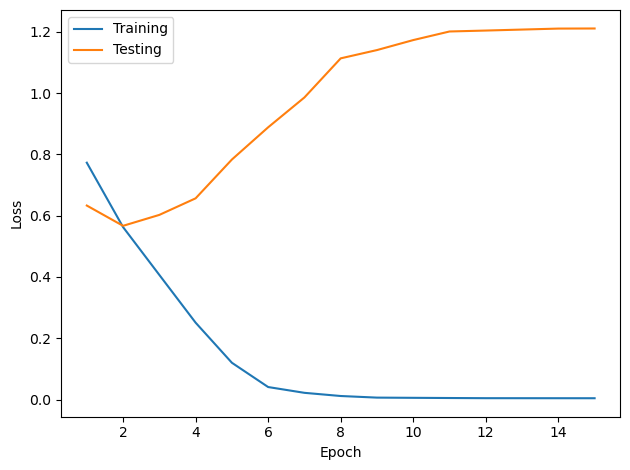

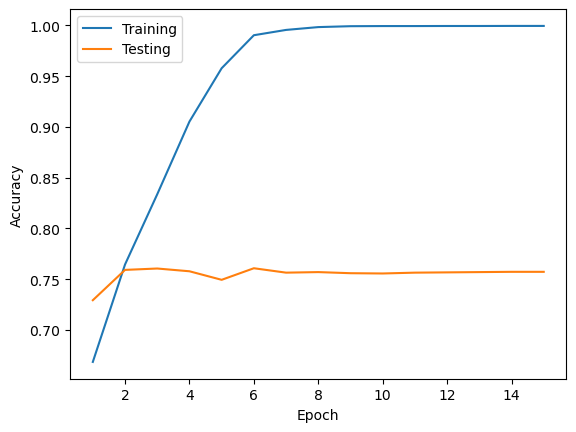

In [25]:
# Evaluation
plot_loss(
    train_loss_list=train_loss_list, valid_loss_list=val_loss_list, results_dir=None
)
plt.show()

plot_accuracy(
    train_acc_list=train_acc_list, valid_acc_list=val_acc_list, results_dir=None
)
plt.show()

#### Predictions

In [31]:
import torch.nn.functional as F


def predict(model, sentence, vocab, tokenizer, device="cpu"):
    """
    For language models, make a prediction for a single sentence using the trained model and return
    the probability vector for all classes.

    We applies the softmax function to the model's output (logits) to get a
    probability distribution over all classes.

    Args:
    model: Trained model (return logits)
    sentence: A string, the sentence to classify
    vocab: Vocabulary object used for the model
    tokenizer: Tokenizer function used to split the sentence into tokens
    device: The device to run the model

    Returns:
    tuple: A tuple containing the predicted class and the probability vector.
           The probability vector is a 1D tensor of shape (num_classes,)
           representing the softmax probabilities for each class.
    """

    model.eval()  # Set model to evaluation mode

    tokens = tokenizer(sentence)  # Tokenize the sentence
    indexed_tokens = [
        get_vocab_index(token, vocab) for token in tokens
    ]  # Convert tokens to indices
    indexed_tokens = [
        index if index != "Not found" else vocab["<unk>"] for index in indexed_tokens
    ]  # Handle unknowns

    length = [len(indexed_tokens)]  # Determine text length
    tensor = (
        torch.LongTensor(indexed_tokens).unsqueeze(0).to(device)
    )  # Convert indices to tensor
    length_tensor = torch.LongTensor(length).to(device)  # Convert length to tensor

    with torch.no_grad():
        logits = model(tensor, length_tensor)  # Get logits from the model
        probabilities = F.softmax(
            logits, dim=1
        )  # Apply softmax to logits to get probabilities

    predicted_class = torch.argmax(
        probabilities, dim=1
    ).item()  # Get the predicted class
    return predicted_class, probabilities.squeeze(
        0
    )  # Return predicted class and probability vector


# Example 1
sentence = "This is such an awesome movie, I really love it!"
predicted_class, probabilities = predict(model, sentence, vocab, tokenizer, "cpu")
print("Predicted class:", predicted_class)
print("Probabilities:", probabilities)

# Example 2
sentence = "Whenever I go to a place that doesn’t take Apple Pay (doesn’t happen too often), \
it’s such a drag. Between ‘contactless Covid’ habits and my getting the Apple Card, I’ve gotten so \
used to Apple Pay that I get seriously annoyed when a store doesn’t take it. It feels like a shock, \
it’s crazy how quickly it took over my shopping routine! I’ve officially been brainwashed by Apple \
because now it feels so inconvenient to even carry a physical card in my pocket"
predicted_class, probabilities = predict(model, sentence, vocab, tokenizer, "cpu")
print("Predicted class:", predicted_class)
print("Probabilities:", probabilities)

Predicted class: 2
Probabilities: tensor([9.0787e-08, 2.3897e-07, 1.0000e+00])
Predicted class: 0
Probabilities: tensor([9.9250e-01, 7.3666e-03, 1.3153e-04])


#### Confusion matrix

In [27]:
def get_predictions2(model, dataloader, device, pad_idx):
    """
    Generate predictions using a RNN/LSTM trained model for the data provided by a DataLoader.

    This function iterates over the DataLoader and processes each batch of text
    using the provided model. It accumulates the model's predictions, the original
    text (as tensors), and the true labels. Since the text data can have variable
    lengths, the function returns a list of tensors for the text batches. The true
    labels and predictions are returned as one-dimensional NumPy arrays.

    Args:
        model (torch.nn.Module): The trained PyTorch model for making predictions.
                                 The model should be in evaluation mode and compatible
                                 with the data provided by the DataLoader.
        dataloader (DataLoader): A PyTorch DataLoader that provides batches of data
                                 for prediction. Each batch should contain text data
                                 and corresponding labels.
        device (torch.device): The device on which the model and data should be processed.
                               Typically 'cpu' or 'cuda'.
        pad_idx (int): The padding index in the vocabulary, used to calculate
                       the actual lengths of the text sequences.

    Returns:
        Tuple[List[torch.Tensor], numpy.ndarray, numpy.ndarray]:
            - A list of tensors, each containing a batch of text sequences.
            - A one-dimensional NumPy array containing the true labels for all samples.
            - A one-dimensional NumPy array containing the predicted labels for all samples.
    """
    model.eval()  # Set the model to evaluation mode
    texts_all, labels_all, predictions_all = [], [], []

    with torch.no_grad():  # Disable gradient computation
        for text_batch, label_batch in dataloader:
            # Calculate the actual lengths of each sequence in the batch
            text_lengths = torch.sum(text_batch != pad_idx, dim=1)

            # Move the batch data to the specified device
            text_batch, label_batch = text_batch.to(device), label_batch.to(device)

            # Get model outputs (logits)
            outputs = model(text_batch, text_lengths)

            # Get predicted labels by finding the maximum logit value
            _, predictions = torch.max(outputs, 1)

            # Accumulate the batches of texts, true labels, and predictions
            texts_all.append(text_batch.cpu())  # Store text tensors
            labels_all.extend(label_batch.cpu().numpy())  # Convert to NumPy and store
            predictions_all.extend(
                predictions.cpu().numpy()
            )  # Convert to NumPy and store

    # Convert lists to NumPy arrays
    labels_all = np.array(labels_all)
    predictions_all = np.array(predictions_all)

    # Return the accumulated texts, labels, and predictions
    return texts_all, labels_all, predictions_all

In [28]:
# Get predictions
texts_all, test_labels, test_predictions = get_predictions2(
    model, test_loader, device, PAD_IDX
)

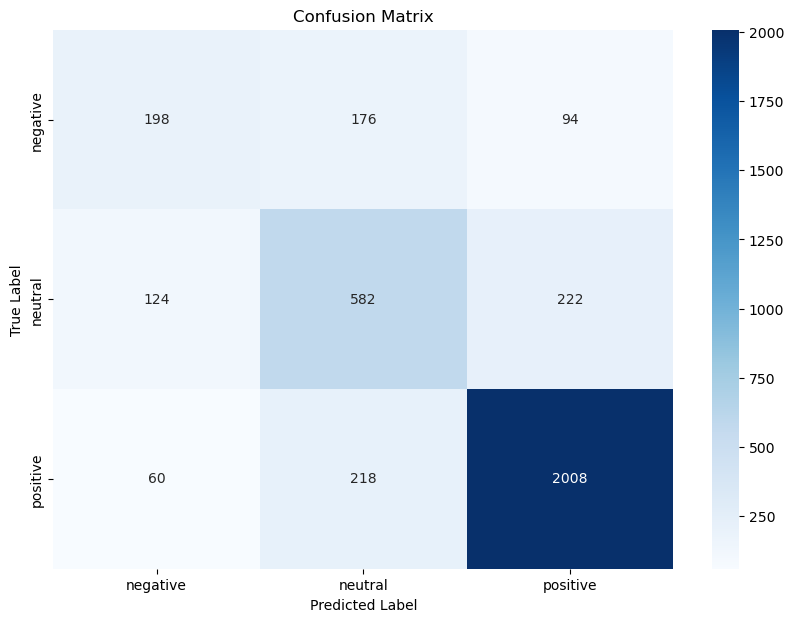

In [29]:
plot_confusion_matrix(test_labels, test_predictions, dict_label)